In [1]:
import matplotlib.pyplot as plt
import time
import os
import pickle

import torch
import numpy as np
from scipy.stats import linregress

from sbi import analysis
from sbi import utils as utils
from sbi.utils.user_input_checks import process_prior

from simulations_model1 import simulator_sbi_entropy
from parsing_functions import save_pickle_data, load_inference_data, extract_specs

from tqdm.notebook import tqdm  # Use tqdm if you're not in a notebook environment

In [2]:
import numpy as np
import torch
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

def simulate_entropy(theta, simulator_to_sbi_entropy):
    x_obs, S = simulator_to_sbi_entropy(theta)
    return S

def compute_entropies_log(n_points, samplings, L_thr, theta_true, simulator_to_sbi_entropy, posterior, n_jobs=10, batch_size=5):
    S = []
    S_mean = []
    S_error = []

    for i in tqdm(range(n_points), desc="Computing entropies"):
        x_obs1, S1 = simulator_to_sbi_entropy(theta_true[i])
        S.append(S1)
        
        samples_i = posterior.sample((samplings,), x=x_obs1, show_progress_bars=False)
        log_prob_samples_i = posterior.log_prob(samples_i, x=x_obs1)
        
        max_log_prob = torch.max(log_prob_samples_i)
        normalized_log_prob_samples_i = log_prob_samples_i / max_log_prob
        threshold = L_thr
        indices = torch.where(normalized_log_prob_samples_i > threshold)[0]
        samples_i_trunc = samples_i[indices]
        log_prob_samples_i_trunc = log_prob_samples_i[indices]
        
       
        S_single_values = Parallel(n_jobs=n_jobs, batch_size=batch_size)(
            delayed(simulate_entropy)(samples_i_trunc[j], simulator_to_sbi_entropy) for j in range(len(samples_i_trunc))
        )
        
        S_single_values = torch.tensor(S_single_values)  # Convert to tensor
        
        S_logprob_products = S_single_values * log_prob_samples_i_trunc
        S2_logprob_products = (S_single_values ** 2) * log_prob_samples_i_trunc
        
        sum_log_prob_trunc = torch.sum(log_prob_samples_i_trunc)
  
        S_mean_i = torch.sum(S_logprob_products) / sum_log_prob_trunc
        S2_mean_i = torch.sum(S2_logprob_products) / sum_log_prob_trunc
        
        S_variance_i = S2_mean_i - (S_mean_i ** 2)
        
        S_error_i = torch.sqrt(S_variance_i)


        S_mean.append(S_mean_i)
        S_error.append(S_error_i)
        
    return S, S_mean, S_error


In [3]:
posterior_dir = 'saved_posteriors'
posterior_name = 'posterior_1000sim_5e+04np_1e-02dt_5os_1e+03pre.pickle'
posterior_path = os.path.join(posterior_dir, posterior_name)

# Extract the specifications
specs_dict = extract_specs(posterior_path)
print(specs_dict)
# Unpack the specifications from the dictionary
num_simulations = specs_dict['num_simulations']
Npts = specs_dict['Npts']
dt = specs_dict['dt']
oversampling = specs_dict['oversampling']
prerun = specs_dict['prerun']

prefix = specs_dict['prefix']
data_type = specs_dict['data_type']

high_tensor = specs_dict['high_tensor']
low_tensor = specs_dict['low_tensor']

with open(posterior_path, "rb") as handle:
    data_posterior = pickle.load(handle)

posterior = data_posterior['posterior']

{'num_simulations': 1000, 'Npts': 50000.0, 'dt': 0.01, 'oversampling': 5, 'prerun': 1000.0, 'low_tensor': tensor([0.0000, 0.1000, 0.0000]), 'high_tensor': tensor([ 4,  3, 15]), 'data_type': 'full', 'prefix': None}


In [4]:
def simulator_to_sbi_entropy(pars):
    return simulator_sbi_entropy(np.array(pars), dt, int(oversampling), int(prerun),int(Npts), prefix= data_type)

prior_sbi = utils.BoxUniform(low=low_tensor, high=high_tensor)

# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior_sbi)

In [5]:
theta_true = prior.sample((1,))
print(theta_true)
# generate our observation
x_obs, S2 = simulator_to_sbi_entropy(theta_true[0])
samples = posterior.sample((100000,), x=x_obs)

tensor([[2.0636, 2.7298, 3.4130]])


Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

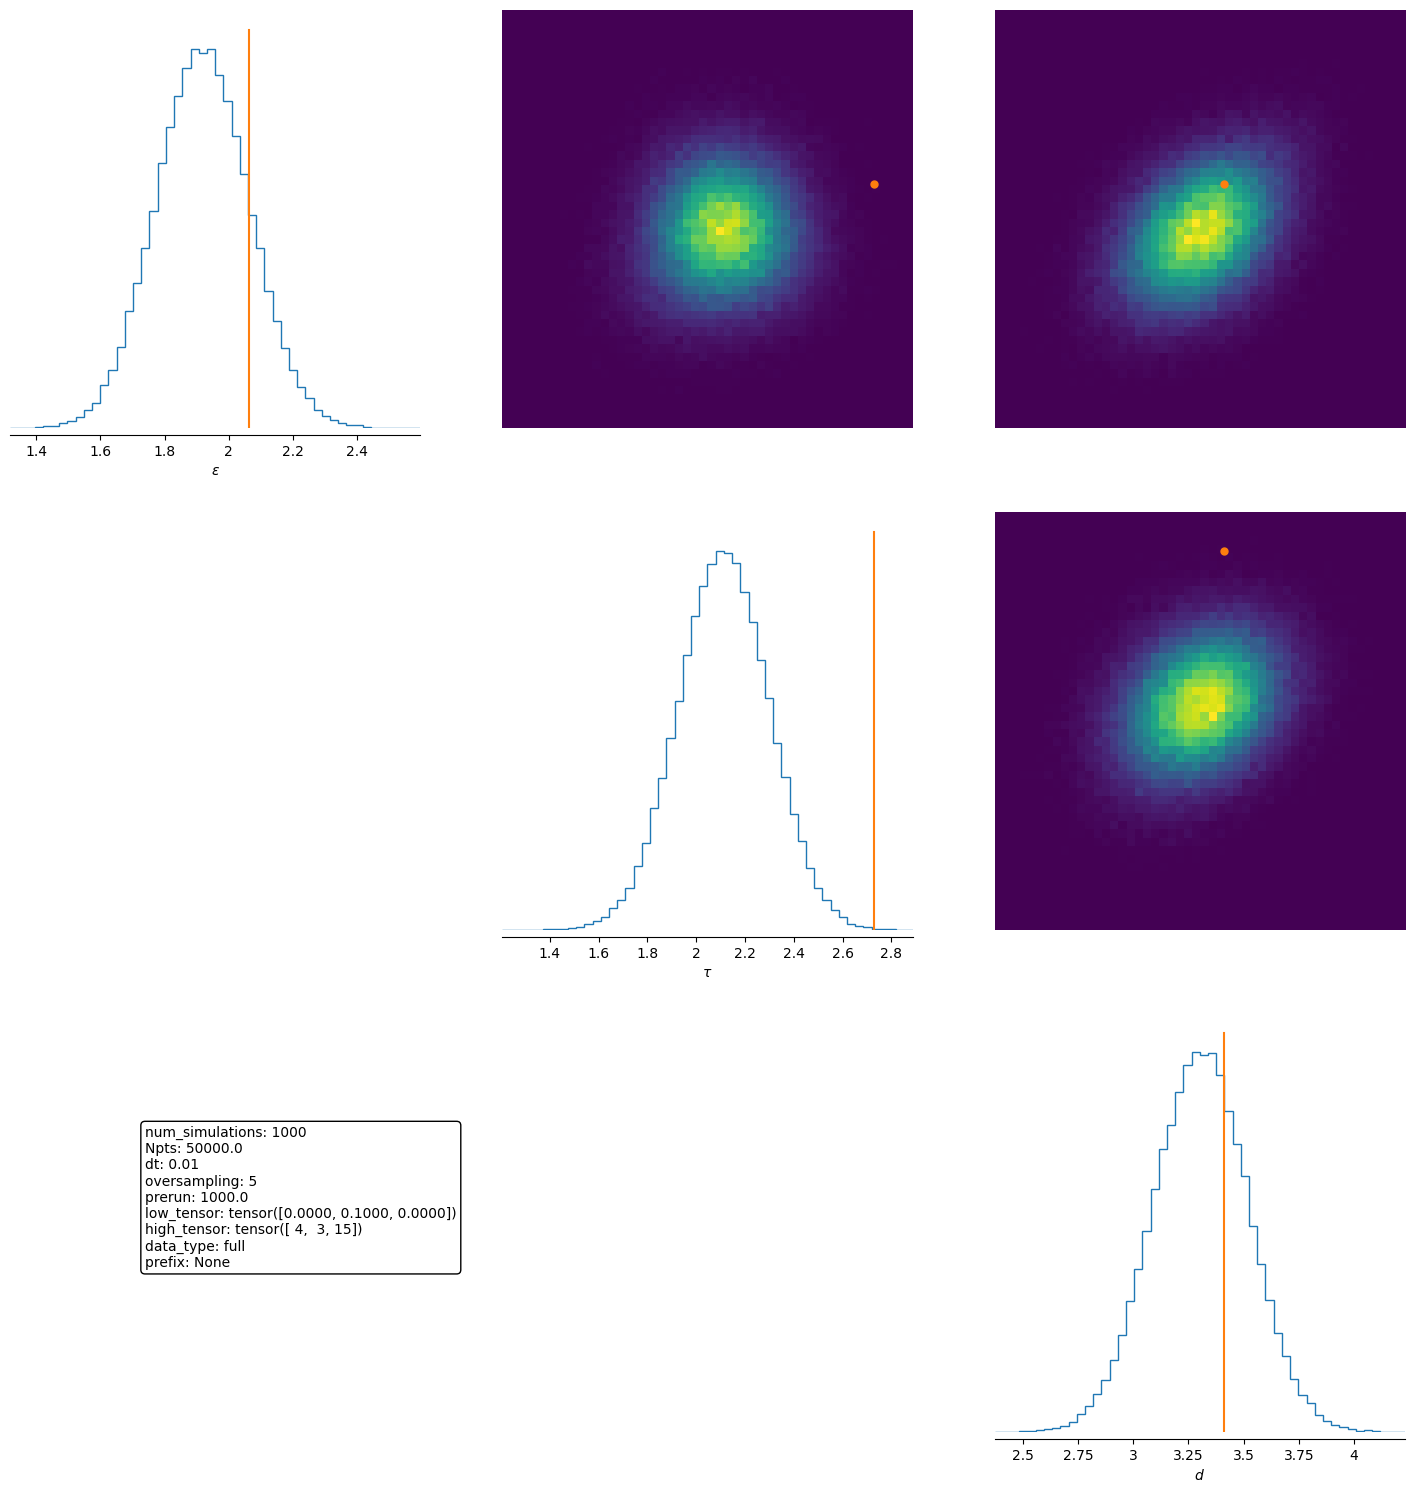

In [6]:
fig,ax = analysis.pairplot(samples, points=theta_true, figsize=(18, 18),labels=[r"$\epsilon$", r"$\tau$", r"$d$"])

fig_save_dir = 'saved_figures'
fig_name = 'analysisSNPE_' + str(specs_dict).replace(' ', '_').replace(':', '_').replace(',', '_').replace("'", "").replace("{", "").replace("}", "").replace("\n", "") +'png.'

# Convert metadata dictionary to a string
metadata_text = "\n".join([f"{key}: {value}" for key, value in specs_dict.items()])

# Add text box with metadata
text_box = fig.text(
    0.2, 0.2, metadata_text,
    fontsize=10,
    verticalalignment='bottom',
    horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=1, boxstyle='round,pad=0.3')
)

# Create directory to save dataset if it doesn't exist
if not os.path.isdir(fig_save_dir): os.makedirs(fig_save_dir)
fig_path = os.path.join(fig_save_dir, fig_name)

fig.savefig(fig_path, dpi = 300)

In [7]:
%%time

n_points = 20
samplings = 1000
L_thr = 0.65

theta_trues = prior.sample((n_points,))

S, S_mean, S_error = compute_entropies_log(n_points, samplings, L_thr,
                                                       theta_trues, simulator_to_sbi_entropy, 
                                                       posterior, n_jobs = 8, batch_size =10)

Computing entropies:   0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 1min 24s, sys: 15.3 s, total: 1min 39s
Wall time: 2min 59s


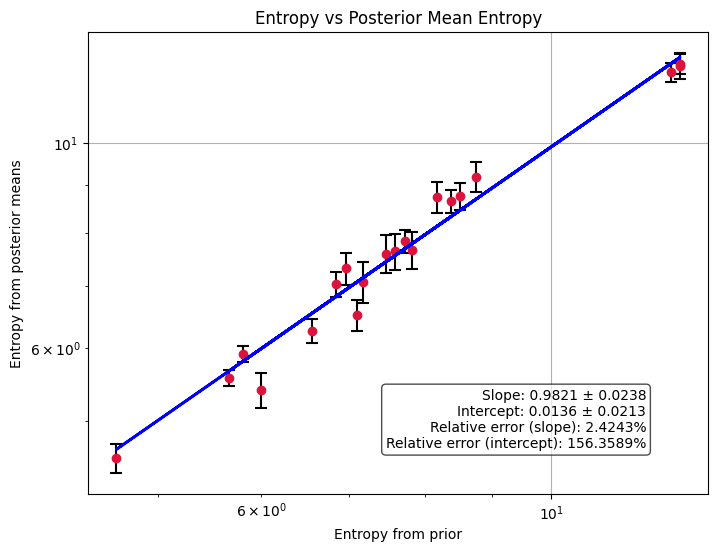

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

# Define linear model
def linear_model(x, a, b):
    return a * x + b

# Fit function with errors
def fit_with_errors(x, y, y_err):
    # Initial guess for parameters
    initial_guess = [1, 0]
    
    # Perform the fit
    popt, pcov = curve_fit(linear_model, x, y, sigma=y_err, absolute_sigma=True, p0=initial_guess)
    
    # Calculate errors for parameters
    perr = np.sqrt(np.diag(pcov))
    return popt, perr

# Example data (replace with your real data)
# S = ...  # Entropie dal prior (x)
# S_mean = ...  # Entropie dai parametri medi del posterior (y)
# S_error = ...  # Errori sulle entropie dal prior (errore sulle y)

# Convert lists to numpy arrays
S = np.array(S)
S_mean = np.array(S_mean)
S_error = np.array(S_error)

# Log-transform the data
log_S = np.log10(S)
log_S_mean = np.log10(S_mean)
log_S_error = S_error / (S_mean * np.log(10))  # Error propagation for logarithm

# Perform the fit on the log-transformed data
popt, perr = fit_with_errors(log_S, log_S_mean, log_S_error)
slope, intercept = popt
slope_err, intercept_err = perr

# Generate the regression line
log_regression_line = intercept + slope * np.array(log_S)

# Calculate relative errors
relative_error_slope = slope_err / slope if slope != 0 else np.nan
relative_error_intercept = intercept_err / intercept if intercept != 0 else np.nan

# Plot scatter plot
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 6))
s = 60
ax2.errorbar(S, S_mean, yerr=S_error, fmt='o', color='crimson', ecolor='black', elinewidth=1.5, capsize=4, capthick=1.5, zorder=2)

# Plot regression line
ax2.plot(S, 10**log_regression_line, color='blue', linewidth=2, zorder=3)

# Add linear regression parameters and relative errors to the plot
regression_text = (
    f"Slope: {slope:.4f} ± {slope_err:.4f}\n"
    f"Intercept: {intercept:.4f} ± {intercept_err:.4f}\n"
    f"Relative error (slope): {relative_error_slope:.4%}\n"
    f"Relative error (intercept): {relative_error_intercept:.4%}"
)
ax2.text(
    0.9, 0.1, regression_text,
    fontsize=10,
    verticalalignment='baseline',
    horizontalalignment='right',
    transform=ax2.transAxes,
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
)

# Set scales to logarithmic
ax2.set_xscale('log')
ax2.set_yscale('log')

# Add labels and grid
ax2.set_xlabel("Entropy from prior")
ax2.set_ylabel("Entropy from posterior means")
ax2.set_title("Entropy vs Posterior Mean Entropy")
ax2.grid(True)

# Save the figure
fig_save_dir2 = 'saved_plots/'
fig_name2 = 'entropyerrlog_' + str(specs_dict).replace(' ', '_').replace(':', '_').replace(',', '_').replace("'", "").replace("{", "").replace("}", "").replace("\n", "") + '.png'

# Create directory to save dataset if it doesn't exist
if not os.path.isdir(fig_save_dir2): os.makedirs(fig_save_dir2)
fig_path2 = os.path.join(fig_save_dir2, fig_name2)

fig2.savefig(fig_path2, dpi=600)

plt.show()

### same plot but without log scale if you want it

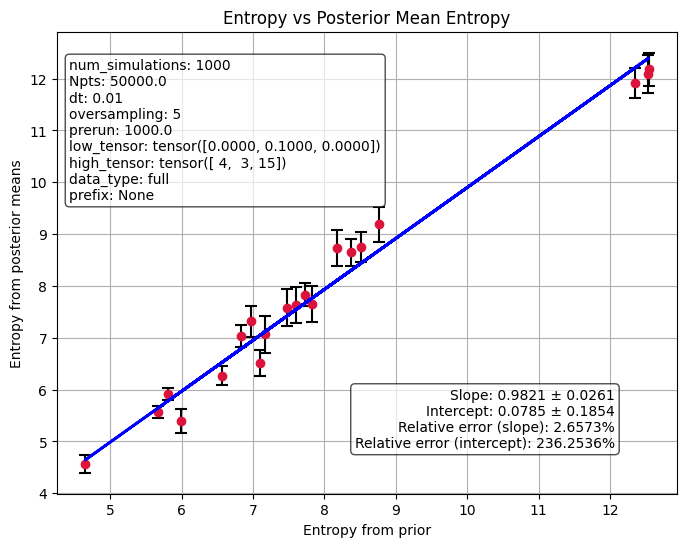

In [9]:
from scipy.optimize import curve_fit

def linear_model(x, a, b):
    return a * x + b



# linear model with y_error handling
def fit_with_errors(x, y, y_err):
    # Funzione di errore combinata
    def combined_error(params, x, y, y_err):
        a, b = params
        model = a * x + b
        return (y - model) / np.sqrt(y_err**2)
    
    # initial parameters guess
    initial_guess = [1, 0]
    
    # fit
    popt, pcov = curve_fit(linear_model, x, y, sigma=y_err, absolute_sigma=True, p0=initial_guess)
    
    # fit error from covariance matrix
    perr = np.sqrt(np.diag(pcov))
    return popt, perr

# fit function
popt, perr = fit_with_errors(S, S_mean, S_error)
slope, intercept = popt
slope_err, intercept_err = perr

# plotting our fit with a line
regression_line = intercept + slope * np.array(S)

relative_error_slope = slope_err / slope if slope != 0 else np.nan
relative_error_intercept = intercept_err / intercept if intercept != 0 else np.nan

# Plot scatter plot
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 6))
s = 60
ax2.errorbar(S, S_mean, yerr=S_error, fmt='o', color='crimson', ecolor='black', elinewidth=1.5, capsize=4, capthick=1.5, zorder=2)

# Plot regression line
ax2.plot(S, regression_line, color='blue', linewidth=2, zorder=3)

# Convert metadata dictionary to a string
metadata_text = "\n".join([f"{key}: {value}" for key, value in specs_dict.items()])

# Add text box with metadata
text_box = fig2.text(
    0.02, .63, metadata_text,
    fontsize=10,
    verticalalignment='bottom',
    horizontalalignment='left',
    transform=ax2.transAxes,
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
)

# Add linear regression parameters and relative errors to the plot
regression_text = (
    f"Slope: {slope:.4f} ± {slope_err:.4f}\n"
    f"Intercept: {intercept:.4f} ± {intercept_err:.4f}\n"
    f"Relative error (slope): {relative_error_slope:.4%}\n"
    f"Relative error (intercept): {relative_error_intercept:.4%}"
)
ax2.text(
    0.9, 0.1, regression_text,
    fontsize=10,
    verticalalignment='baseline',
    horizontalalignment='right',
    transform=ax2.transAxes,
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
)

# Add labels and grid
ax2.set_xlabel("Entropy from prior")
ax2.set_ylabel("Entropy from posterior means")
ax2.set_title("Entropy vs Posterior Mean Entropy")
ax2.grid(True)

# Save the figure
fig_save_dir2 = 'saved_plots/'
fig_name2 = 'entropy_' + str(specs_dict).replace(' ', '_').replace(':', '_').replace(',', '_').replace("'", "").replace("{", "").replace("}", "").replace("\n", "") + '.png'

# Create directory to save dataset if it doesn't exist
if not os.path.isdir(fig_save_dir2): os.makedirs(fig_save_dir2)
fig_path2 = os.path.join(fig_save_dir2, fig_name2)

fig2.savefig(fig_path2, dpi=600)

plt.show()